In [8]:
from utils import *
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.decomposition import PCA

In [9]:
fd_collection = getCollection("team_5_mwdb_phase_2", "fd_collection")

In [10]:
selected_feature_model = "fc_fd"

t = int(input("Enter value of t: "))
if t < 1:
    raise ValueError("t should be a positive integer")

num_layers = int(input("Enter the number of layers: "))
if num_layers < 1:
    raise ValueError("num_layers should be a positive integer")

num_hashes_per_layer = int(input("Enter the number of hashes per layer: "))
if num_hashes_per_layer < 1:
    raise ValueError("num_hashes_per_layer should be a positive integer")

In [11]:
all_images = list(fd_collection.find())
all_images = sorted(all_images, key = lambda x: x["image_id"])

odd_image_ids = [img["image_id"] for img in all_images if img["image_id"] % 2 == 0]

even_image_labels = [img["true_label"] for img in all_images if img["image_id"] % 2 == 0]
odd_image_labels = [img["true_label"] for img in all_images if img["image_id"] % 2 != 0]

feature_vectors = [np.array(img[selected_feature_model]).flatten() for img in all_images]

total_len = len(feature_vectors)
even_feature_vectors = []
odd_feature_vectors = []

for i in range(total_len):
  if i % 2 == 0:
    even_feature_vectors.append(feature_vectors[i])
  else:
    odd_feature_vectors.append(feature_vectors[i])


even_feature_vectors = np.array(even_feature_vectors)
odd_feature_vectors = np.array(odd_feature_vectors)

odd_len = odd_feature_vectors.shape[0]
even_len = even_feature_vectors.shape[0]

In [12]:
num_vectors = even_feature_vectors.shape[0]
vector_dimension = even_feature_vectors.shape[1]

lsh = LSH(even_feature_vectors, num_layers, num_hashes_per_layer)

In [13]:
query_image_id = int(input("Enter value of query_image_id: "))
if query_image_id < 1:
    raise ValueError("query_image_id should be a positive integer")

query_vector = np.array(odd_feature_vectors[(query_image_id // 2)])

similar_images = lsh.find_similar(query_vector, t, query_image_id // 2)
unique_images_count = lsh.get_unique_images_considered_count()
overall_images_count = lsh.get_overall_images_considered_count()


print("Number of unique images considered:", unique_images_count)
print("Overall number of images considered:", overall_images_count, "\n")

print(f"Input image ID: {query_image_id}")
print(f"Input image label: {odd_image_labels[query_image_id // 2]}")
print(f"{len(similar_images)} images")
for sim in similar_images:
    print(f"Label: {even_image_labels[sim]}, ID: {sim * 2}")

Number of unique images considered: 4015
Overall number of images considered: 4015 

Input image ID: 2501
Input image label: 5
10 images
Label: 5, ID: 2530
Label: 5, ID: 2618
Label: 5, ID: 2412
Label: 5, ID: 2630
Label: 5, ID: 2472
Label: 5, ID: 2612
Label: 5, ID: 2514
Label: 5, ID: 2722
Label: 5, ID: 2610
Label: 5, ID: 2590


Query Image


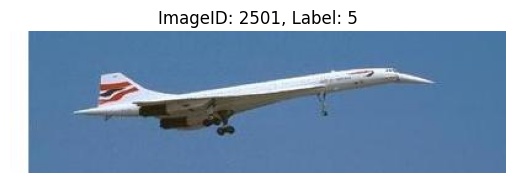

10 similar images as per LSH


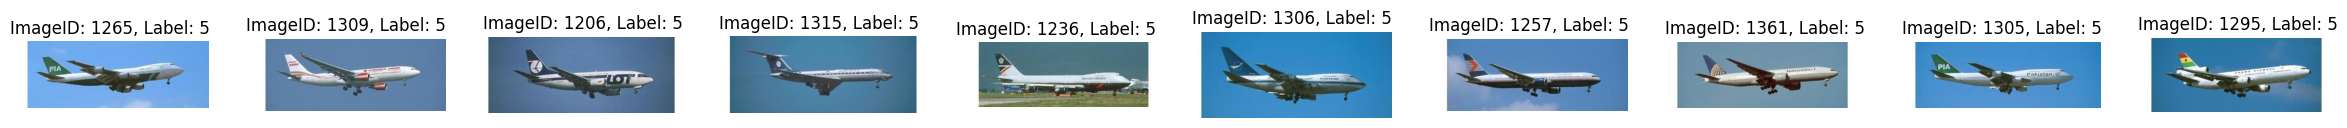

In [14]:
dataset = loadDataset(Caltech101)

print("Query Image")
query_img, query_label = dataset[query_image_id]
plt.imshow(transforms.ToPILImage()(dataset[query_image_id][0]))
plt.title(f"ImageID: {query_image_id}, Label: {query_label}")
plt.axis("off")
plt.show()


print(f"{t} similar images as per LSH")

fig, axs = plt.subplots(1, t, figsize=(30, 8))
for idx, img_id in enumerate(similar_images):
    cur_img, cur_label = dataset[img_id * 2]
    axs[idx].imshow(transforms.ToPILImage()(cur_img))
    axs[idx].set_title(f"ImageID: {img_id}, Label: {cur_label}")
    axs[idx].axis("off")
plt.show()